# Set-up

In [1]:
import os
import pickle
import math
import copy

from datetime import datetime
from itertools import chain
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import activations, layers, optimizers, regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.constraints

import hyperopt
from hyperopt import *
import hyperopt.plotting
import scipy.optimize

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"  # should shut TF up a bit

# Next two lines: non-working tensorflow-determinism flags:
os.environ['TF_DETERMINISTIC_OPS'] = "1" 
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # not the official command but seen somewhere

os.environ['PYTHONHASHSEED'] = "1"

VAL_SIZE = 10**4
TEST_SIZE = 10**5
TEST_SEED = 1337
np.set_printoptions(threshold=256)

sns.set()
rc = {
    "font.family": "serif",
    "font.serif": "STIXGeneral",
    "mathtext.fontset": "stix",
    "figure.figsize": [6.5, 4],
    "figure.dpi": 150,
}
plt.rcParams.update(rc)

In [3]:
try: 
    from google.colab import drive
    drive.mount('/content/drive/',)
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/Thesis/')
except:
    COLAB = False

LOSS_FOLDER = 'test_losses/'

Mounted at /content/drive/
/content/drive/MyDrive/Thesis


# Data generation (``SimulateData``)

In [4]:
def one_hot_from_probs(probs, seed=None):
    # Assign sample to category with a categorical probability.
    if seed is not None:
        np.random.seed(seed)
    K = probs.shape[1]
    Y_cat = np.array([np.random.choice(K, 1, p=p) for p in probs])
    return np.eye(K)[Y_cat.reshape(-1,)]


def sit_to_let_num(sit, short=False):
    # Go from $X_{\mathrm{B}};\ \mathbf{p}_2$ to X_B; p_2 or just B2
    # Makes some strong assumptions, but the rest wouldn't work if sit were wrong anyway.
    letter = sit.split('rm{')[1][0]
    number = sit[-2]
    return letter, number

def make_X_hist(X, Y, situation=None):
    plt.figure()
    if X.ndim == 1:
        plt.xlabel('$x$')
        hx_sum = 0
        for k in range(Y.shape[1]):
            if situation is not None:
                X_code, p_int = sit_to_let_num(situation)
                s = f'$\mathrm{{\mathbb{{P}}}}(Y_{k+1} = 1\ |\ X_{X_code} \in [$bin around $ x])$'
            else:
                s = f'$\mathrm{{\mathbb{{P}}}}(Y_{k+1} = 1\ |\ X \in [$bin around $ x])$'
            if k == 0:
                hx, bins, bars = plt.hist([X[i] for i in range(len(X)) if Y[i, k] == 1], 
                                        bins=40, density=True, alpha=.4, label=s)
            else:
                hx, _, bars = plt.hist([X[i] for i in range(len(X)) if Y[i, k] == 1], bins=bins, 
                                      bottom=hx_sum/Y.shape[1], density=True, alpha=.4, label=s)
            hx_sum += hx
            for item in bars:
                h = item.get_height()
                item.set_height(h / Y.shape[1])
    
        if False and situation == "$X_{\mathrm{A}};\ \mathbf{p}_2$":
            print("DOING SOMETHING WEIRD FOR A PRESENTATION PICTURE!")
            # for k in range(Y.shape[1]):
            #     s = f'$\mathrm{{\mathbb{{P}}}}(Y_{k+1} = 1\ |\ X \in [$bin around $ x])$'
            #     plt.legend().get_texts()[0].set_text(s)
            plt.hlines(1, 0, 1, linestyles='dashed', label='Prob. density func. $X_A$')
            plt.gca().set_prop_cycle(None)  # use same colours as hist
            order = np.argsort(X)
            shift = - np.math.pi / 2
            def f1(X): return (np.cos(2 * np.math.pi * X + shift) + 1) / 2
            def f2(X): return 1 - f1(X)
            plt.plot(X[order], f1(X[order]), label='$p_1(x)=(1+\sin(2\pi x))\ /\ 2$')
            plt.plot(X[order], f2(X[order]), label='$p_2(x)=(1-\sin(2\pi x))\ /\ 2$')

        plt.ylim((0, max(hx_sum) / Y.shape[1]))
    else:
        print("Not making a 2D histogram.")


class SimulateData(object):
    def __init__(self, situation, n, seed=None):
        self.situation = situation
        self.n = n

        if seed is not None:
            np.random.seed(seed)  # also the SciPy seed
        self.seed = seed

        self.X, self.funcs = self.situational_stuff()
        self.d = 1 if self.X[0].ndim == 0 else self.X[0].shape
        self.K = len(self.funcs)

        self.f_X = np.array([f(self.X) for f in self.funcs]).T
        self.Y_prob = np.array([self.f_X[i] / f_X_sums
                                for i, f_X_sums in enumerate(self.f_X.sum(axis=1))])
        # ^ should do nothing with our p's that already sum to 1 everywhere.

        self.Y_one_hot = one_hot_from_probs(self.Y_prob)

    def unif_rejection_sampling(self, p):
        # Rejection sampling from density function p; proposal is unif[0, 1].
        q_pdf = ss.uniform().pdf  # uses np.random (so seed is set)
        q_sample = np.random.uniform

        grid = np.linspace(0, 1, 1000)
        p_grid = [p(g) for g in grid]
        m = max(p_grid) * 2.4  # should divide by q_pdf(grid) but that's always 1.
        # The 2 factor is just to be sure m * q > p. Proportion accepted ~ 1/m.

        X = []
        while len(X) < self.n:
            z = q_sample()
            if np.random.uniform(0, m * q_pdf(z)) <= p(z):
                X.append(z)
        return np.array(X)


    def empirical_svb(self, tau=0.05, n_t=2000, save_to_pdf=False):
        old_size = plt.rcParams["figure.figsize"] 
        plt.rcParams["figure.figsize"] = (3, 3)
        t_space = np.geomspace(np.finfo(float).eps, 1, n_t)  # denser where small.
        stop = np.argmax(t_space > tau)

        # Probably more complicated than it should be. But first get all probabilities.
        p_X_smaller = [[-1 for _ in range(self.K)] for _ in t_space]
        for i, t in enumerate(t_space):
            for k in range(self.K):
                p_X_smaller[i][k] = np.mean(self.Y_prob[:, k] <= t)
        p_X_smaller = np.array(p_X_smaller)
        
        # Then fit the formulas and store the worst k.
        worst_k = min_res1 = 9999
        res_list = []
        for k in range(self.K):
            y = [max(np.finfo(float).eps, yi) for yi in p_X_smaller[:stop, k]]
            x = np.array(t_space[:stop])
            def chisq_n_y(theta):
                diff = y - (theta[0] * x ** theta[1])
                return sum(diff ** 2)
            res = scipy.optimize.dual_annealing(chisq_n_y, [(0, 10), (0, 1)], seed=0)
            res_list.append(res)
            formula = f'${res.x[0].round(4)} t^{{{res.x[1].round(4)}}}$'
            print(f"k={k}: C t^α fit for t <= {tau}: {formula}")
            if res.x[1] < min_res1:
                min_res1 = res.x[1]
                worst_k = k

        plt.figure()
        plt.xlabel('$t$')
        X_code, p_int = sit_to_let_num(self.situation)
        formula = f'${res_list[worst_k].x[0].round(4)} t^{{{res_list[worst_k].x[1].round(4)}}}$'
        s = '$\mathrm{{\mathbb{{P}}}}(p_{0}^{1}(X_{2} \leq t)$'.format(worst_k + 1, p_int, X_code)
        # ^ now always a small X, I used to have a fix with if .shape etc., apparently lost.
        plt.plot(t_space, p_X_smaller[:, worst_k], label=s)
        plt.plot(t_space[:stop], res_list[worst_k].x[0] * t_space[:stop] ** res_list[worst_k].x[1], 
                 '--', color='black', label=formula)
        plt.legend()
        if save_to_pdf:
            plt.savefig(f'Pictures/emp_a_{self.situation}_{self.n}_{self.seed}.pdf', 
                        format='pdf', pad_inches=.01, bbox_inches='tight')
        plt.show()
        plt.rcParams["figure.figsize"] = old_size

    def situational_stuff(self):
        # I want the situations like "X_{\mathrm{A}}; \mathbf{p}_1"

        if 'X_{\mathrm{A}}' in self.situation:
            print(f"Generating {self.n} samples from 1d uniform.")
            X = np.random.uniform(size=self.n)
        elif 'X_{\mathrm{B}}' in self.situation:
            # Change bot and top to test the big lemma.
            bot = 0
            top = 2
            slope = (top - bot) / 0.25
            print(f"Generating {self.n} samples from {top}-{bot} pyrams with {slope}x slope.")
            def p(x):
                if x   <= .25: return top - slope * x
                elif x <= .5: return bot + slope * (x - .25)
                elif x <= .75: return top - slope * (x - .5)
                else: return bot + slope * (x - .75)
            X = self.unif_rejection_sampling(p)
        elif '\mathbf{X}_{\mathrm{C}}' in self.situation:
            print(f"Generating {self.n} samples from 2d uniform.")
            X = np.random.uniform(size=(self.n, 2))
        else:
            print("Invalid X")

        if '\mathbf{p}_1' in self.situation:
            def f1(X): return (np.cos(2 * np.math.pi * X) + 1) / 2
            def f2(X): return 1 - f1(X)
            funcs = [f1, f2]
        elif '\mathbf{p}_2' in self.situation:
            shift = - np.math.pi / 2
            def f1(X): return (np.cos(2 * np.math.pi * X + shift) + 1) / 2
            def f2(X): return 1 - f1(X)
            funcs = [f1, f2]
        elif '\mathbf{p}_3' in self.situation:
            def f1(X): return (np.cos(2 * np.math.pi * X) + 1) / 3
            def f2(X): return 2/3 - (np.cos(2 * np.math.pi * X) + 1) / 3
            def f3(X): return [1/3 for _ in X]
            funcs = [f1, f2, f3]
        elif '\mathbf{p}_4' in self.situation:
            def f1(X): return 2/3 * X
            def f2(X): return 2/3 - (2/3) * X
            def f3(X): return [1/3 for _ in X]
            funcs = [f1, f2, f3]
        elif '\mathbf{p}_5' in self.situation:
            def f1(X): return (X.sum(axis=1) / 2) ** 2
            def f2(X): return 1 - f1(X)
            funcs = [f1, f2]
        elif '\mathbf{p}_6' in self.situation:
            def f1(X): return (X.sum(axis=1) / 2) ** 4
            def f2(X): return 1 - f1(X)
            funcs = [f1, f2]
        else:
            print("Invalid p")
        
        return X, funcs
    

    def visualize(self, save_to_pdf=False):
        if self.X.ndim > 2:
            print("$\mathbf{X}$ dimensionality too high to visualize well.")
            return -1

        if self.X.ndim == 1:
            make_X_hist(self.X, self.Y_one_hot, self.situation)
        elif self.X.ndim == 2:
            order = np.argsort(self.X[:, 0])
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
            X_code, p_int = sit_to_let_num(self.situation)
            for i in range(self.Y_prob.shape[1]):
                m = '.' if i % 2 else 'x'
                ax.scatter(self.X[:, 0], self.X[:, 1], self.Y_prob[:, i],
                           label=f'$p^{p_int}_{i+1}(\mathbf{{x}})$', marker=m, alpha=.6)
            ax.set_xlabel('$x_1$')
            ax.set_ylabel('$x_2$')
            ax.legend()
            ax.elev -= 8
        else:
            print("Not visualizing, too high-dimensional")
        
        plt.legend()#loc='lower right')
        if save_to_pdf:
            pad = 0.01 if self.X.ndim == 1 else 0.2
            plt.savefig(f'Pictures/sim_{self.situation}_{self.n}_{self.seed}.pdf', 
                        format='pdf', pad_inches=pad, bbox_inches='tight')
        else:
            plt.show()


$X_{\mathrm{A}};\ \mathbf{p}_2$
Generating 4096 samples from 1d uniform.
k=0: C t^α fit for t <= 0.05: $0.7439 t^{0.5477}$
k=1: C t^α fit for t <= 0.05: $0.694 t^{0.5133}$


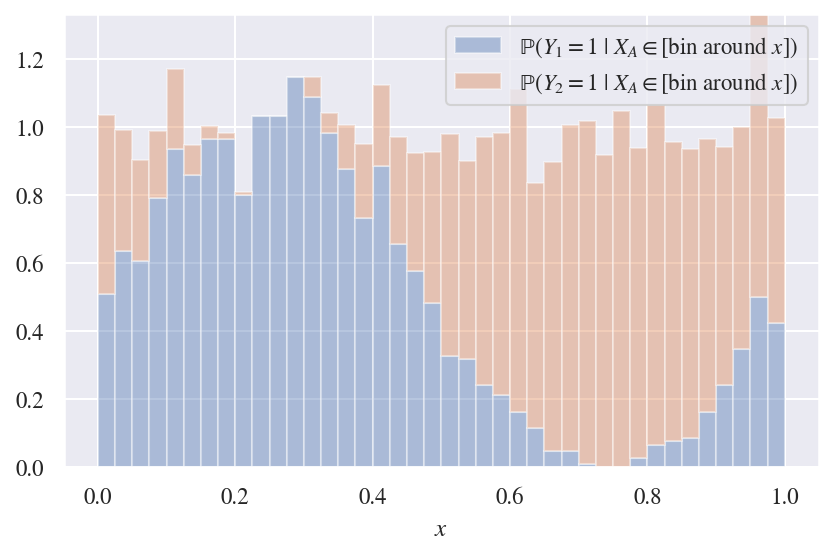

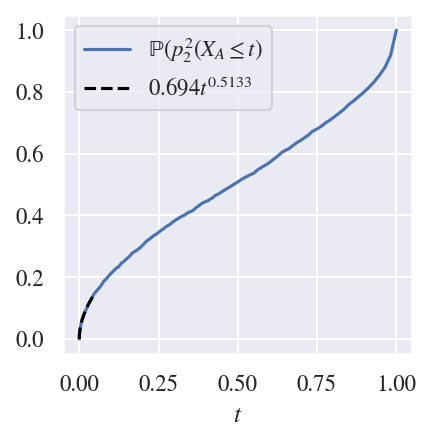


$X_{\mathrm{B}};\ \mathbf{p}_2$
Generating 4096 samples from 2-0 pyrams with 8.0x slope.
k=0: C t^α fit for t <= 0.05: $0.9249 t^{0.9893}$
k=1: C t^α fit for t <= 0.05: $0.6723 t^{1.0}$


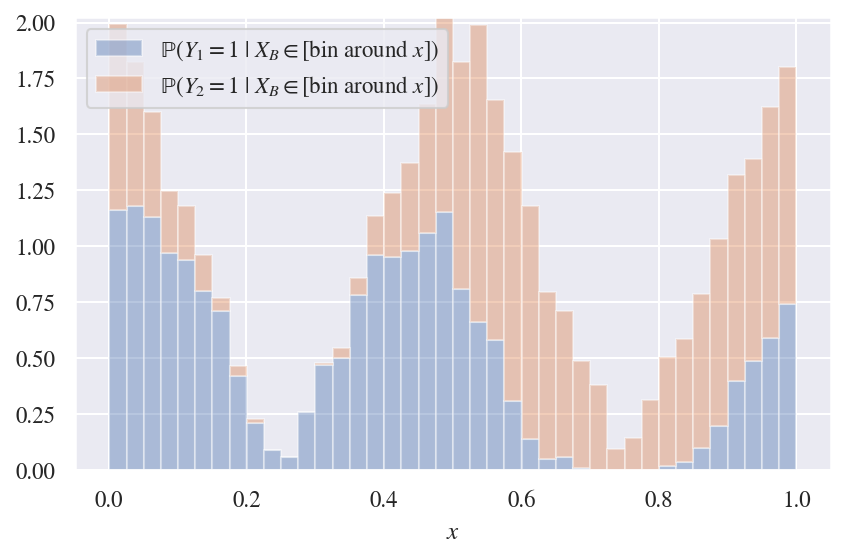

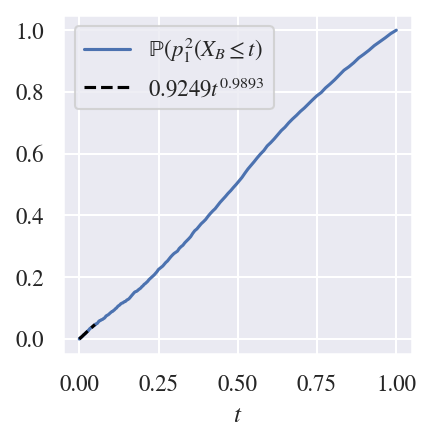


$X_{\mathrm{A}};\ \mathbf{p}_3$
Generating 4096 samples from 1d uniform.
k=0: C t^α fit for t <= 0.05: $0.7576 t^{0.5053}$
k=1: C t^α fit for t <= 0.05: $0.8762 t^{0.5128}$
k=2: C t^α fit for t <= 0.05: $0.0 t^{1.0}$


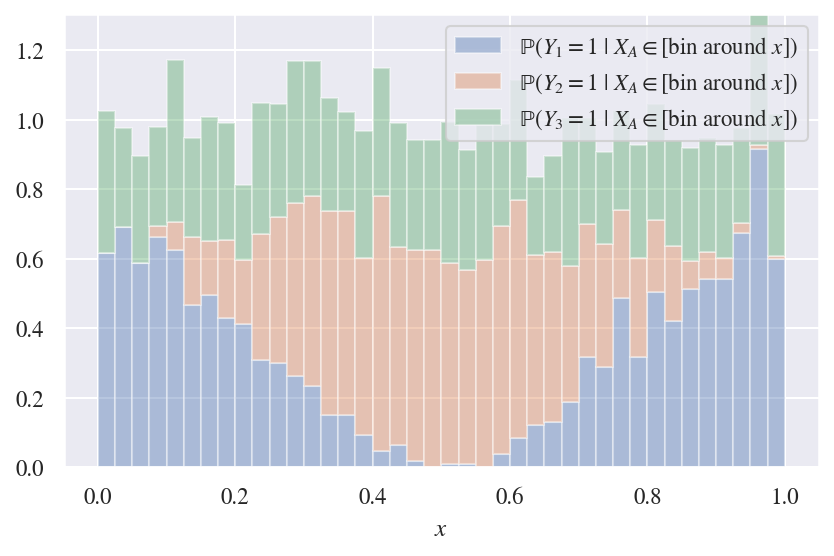

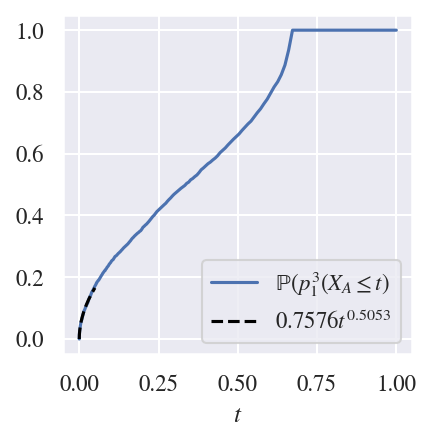


$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_5$
Generating 4096 samples from 2d uniform.
k=0: C t^α fit for t <= 0.05: $1.6475 t^{0.9446}$
k=1: C t^α fit for t <= 0.05: $0.0073 t^{1.0}$


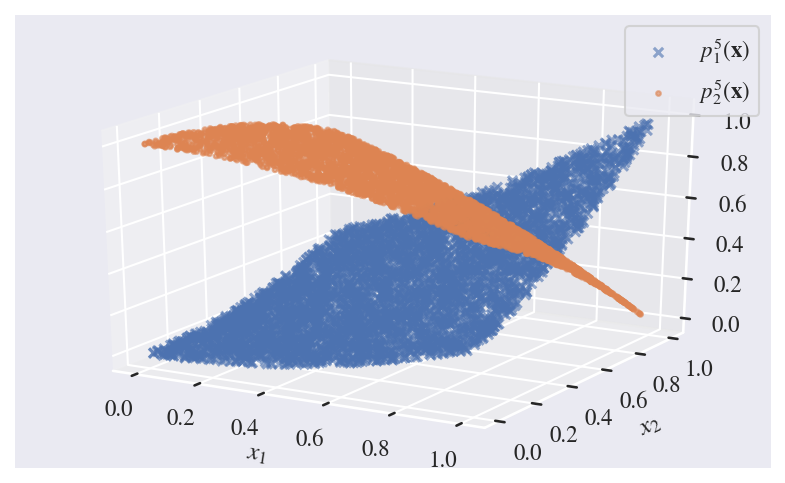

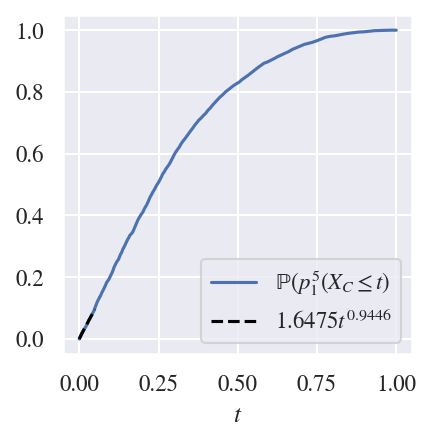


$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_6$
Generating 4096 samples from 2d uniform.
k=0: C t^α fit for t <= 0.05: $2.0735 t^{0.4995}$
k=1: C t^α fit for t <= 0.05: $0.0 t^{1.0}$


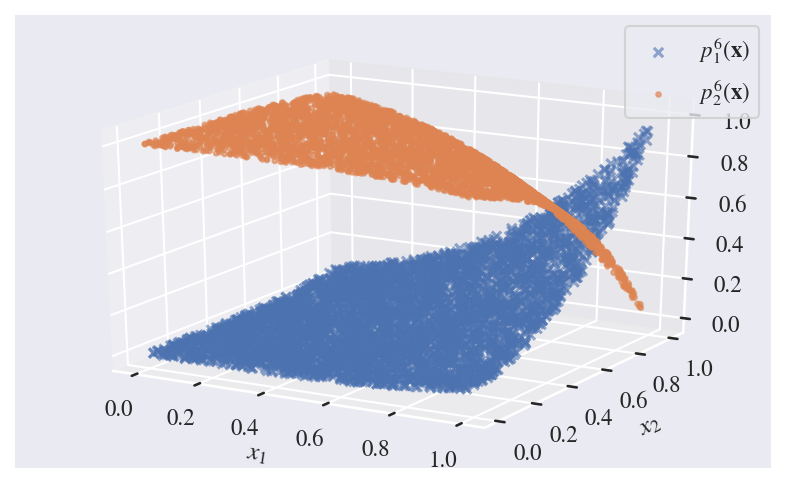

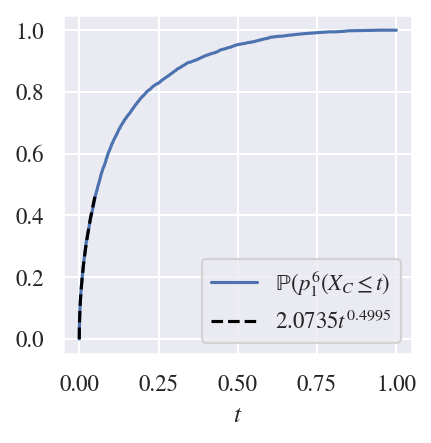

In [5]:
if True:
    situation_list = [
        "$X_{\mathrm{A}};\ \mathbf{p}_2$",
        "$X_{\mathrm{B}};\ \mathbf{p}_2$",
        "$X_{\mathrm{A}};\ \mathbf{p}_3$",
        "$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_5$",
        "$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_6$"
    ]
    for situation in situation_list:
        print(); print(situation)
        train = SimulateData(situation, 4096, seed=0)
        train.visualize(save_to_pdf=True)
        train.empirical_svb(save_to_pdf=True)

# Network (``SingleNetwork``)

In [6]:
def dict_printer(d, digits=4):
    for key in d.keys():
        dk = d[key]
        if type(dk) != float: print(key, ':', dk)
        else: print(key, ':', np.round(dk, digits))

def tf_cross_ent(true, pred):
    return tf.keras.losses.categorical_crossentropy(true, pred).numpy().mean()

def tf_kl(true, pred):
    return tf.keras.losses.KLDivergence()(true, pred).numpy().mean()

def tf_mse(true, pred):
    return tf.keras.losses.MeanSquaredError()(true, pred).numpy()


class SingleNetwork(object):
    def __init__(self, train, val, hidden_widths=[16 for _ in range(8)], l1=.0002):
        self.train = copy.deepcopy(train)
        self.val = copy.deepcopy(val)

        # Need columns
        if self.train.X.ndim == 1:
            self.train.X = self.train.X.reshape(-1, 1)
            self.val.X = self.val.X.reshape(-1, 1)

        self.model = self.initialize_model(hidden_widths, l1)
        self.l1 = l1
        self.history = None
        self.seed = None
        self.losses = None
        self.note = "No bias reg or bounds. He normal. .005 min delta, 500 epochs, " + \
                    "10% patience, bs 128."

    def initialize_model(self, hidden_widths, l1):
        # ReLU activations for hidden layers and final, softmax without weights before output.
        norm = tensorflow.keras.constraints.max_norm(1.0)

        m = [self.train.X[0].shape, *hidden_widths, self.train.K]
        model = tf.keras.models.Sequential(name=f'L-{len(hidden_widths)}-m_0-{m[0][0]}')

        model.add(Dense(m[1], input_shape=m[0], activation='relu', name=f'm_0__to__m_1',
                        kernel_regularizer=regularizers.l1(l1),
                        #bias_regularizer=regularizers.l1(l1),
                        #kernel_constraint=norm, bias_constraint=norm,
                        kernel_initializer="he_normal"))
        for i in range(2, len(m) - 1):
            model.add(Dense(m[i], activation='relu', name=f'm_{i-1}__to__m_{i}',
                            kernel_regularizer=regularizers.l1(l1),
                            #bias_regularizer=regularizers.l1(l1),
                            #kernel_constraint=norm, bias_constraint=norm,
                            kernel_initializer="he_normal"))
        model.add(Dense(m[-1], activation='softmax', name=f'm_{len(m)-2}__to__m_{len(m)-1}',
                            kernel_regularizer=regularizers.l1(l1),
                            #bias_regularizer=regularizers.l1(l1),
                            #kernel_constraint=norm, bias_constraint=norm,
                            kernel_initializer="glorot_uniform"))
        return model

    def train_network(self, opt=0.0003, viz=0, seed=None, epochs=500, bs=128, md=.005):
        # On (default) arguments: Adam default lr 0.001 seems too high, epochs might seem high
        # but we regularize and early stop if not improving by at least md over 10% of epochs.
        # Learning rate will usually be specified in function call, btw.
        
        if type(opt) is float:
            opt = optimizers.Adam(opt)
        
        if seed is not None:
            tf.random.set_seed(seed)
            self.seed = seed

        if viz > 1:
            print(self.model.summary())
       
        # Doesn't feature in thesis anymore, but calculates probability-losses per epoch...
        history_KL_val_prob = []
        history_MSE_val_prob = []
        history_NLL_val_prob = []
        class IntervalEvaluation(Callback):
            def __init__(self, validation_data=()):
                super().__init__()
                self.X_val, self.y_val_prob = validation_data

            def on_epoch_end(self, epoch, logs={}):
                y_pred = self.model.predict(self.X_val, verbose=0)
                true_KL_div = tf_kl(self.y_val_prob, y_pred)
                history_KL_val_prob.append(true_KL_div)
                true_MSE = tf_mse(self.y_val_prob, y_pred)
                history_MSE_val_prob.append(true_MSE)
                true_NLL = tf_cross_ent(self.y_val_prob, y_pred)
                history_NLL_val_prob.append(true_NLL)
        
        # The second and third option are only for demonstration purposes!!!
        patience = round(0.1 * epochs)
        if True:
            self.model.compile(opt, 'categorical_crossentropy')
            es = tf.keras.callbacks.EarlyStopping('val_loss', min_delta=md, 
                                                  patience=patience, verbose=viz, 
                                                  restore_best_weights=True)
        elif False:
            print("Using non-validation (so training) loss for early stopping!")
            self.model.compile(opt, 'categorical_crossentropy')
            es = tf.keras.callbacks.EarlyStopping('loss', min_delta=md, 
                                                  patience=patience, verbose=viz, 
                                                  restore_best_weights=True)
        else:
            print("Using label MSE for early stopping (and prob. as metric)")
            self.model.compile(opt, 'categorical_crossentropy', metrics=['mse'])
            es = tf.keras.callbacks.EarlyStopping('val_mse', min_delta=md / 2, 
                                                  patience=patience, verbose=viz, 
                                                  restore_best_weights=True)

        cb = [es]#, IntervalEvaluation(validation_data=(self.val.X, self.val.Y_prob))]
        self.history = self.model.fit(self.train.X, self.train.Y_one_hot, epochs=epochs,
                                      callbacks=cb, batch_size=bs, use_multiprocessing=True,
                                      validation_data=(self.val.X, self.val.Y_prob),
                                      verbose=0 if viz < 2 else 2, shuffle=False)

        train_pred = self.model.predict(self.train.X)
        val_pred = self.model.predict(self.val.X)
        # Don't use e.g. np.min(self.history.history['val_loss']) since we need val_pred anyway.
        self.losses = {
            'NLL train labels': tf_cross_ent(self.train.Y_one_hot, train_pred),
            'NLL train prob.': tf_cross_ent(self.train.Y_prob, train_pred),
            "NLL val. labels": tf_cross_ent(self.val.Y_one_hot, val_pred),
            "NLL val. prob.": tf_cross_ent(self.val.Y_prob, val_pred),
            "KL train labels": tf_kl(self.train.Y_one_hot, train_pred),
            "KL train prob.": tf_kl(self.train.Y_prob, train_pred),
            "KL val. labels": tf_kl(self.val.Y_one_hot, val_pred),
            "KL val. prob.": tf_kl(self.val.Y_prob, val_pred),
            "MSE train prob.": tf_mse(self.train.Y_one_hot, train_pred),
            "MSE val. prob.": tf_mse(self.val.Y_prob, val_pred)
        }

        # From the now not-used callback...
        # self.history.history['NLL val. prob.'] = history_NLL_val_prob
        # self.history.history['KL val. prob.'] = history_KL_val_prob
        # self.history.history['MSE val. prob.'] = history_MSE_val_prob
        # if viz > 0:
        #     self.plot_history(False)

    def plot_history(self, save_to_pdf):
        old_size = plt.rcParams["figure.figsize"] 
        plt.rcParams["figure.figsize"] = (old_size[0] * 0.8, old_size[1] * 0.6)
        hist = pd.DataFrame(self.history.history)
        hist = hist[['loss', 'val_loss']]
        c = {'loss': '$\operatorname{NLL}(\widehat{\mathbf{p}} | $training set$)$', 
             'val_loss': '$\operatorname{NLL}(\widehat{\mathbf{p}} | $validation set$)$'}
        hist_copy = hist.rename(columns=c)
        hist_copy.plot()
        plt.title('')
        plt.legend(loc='lower left')
        plt.xlabel('Epoch')
        plt.ylim(bottom=0)
        if save_to_pdf:
            s = f'Pictures/eval_{self.train.situation}'
            plt.savefig(s + f'_{self.train.n}_{self.train.seed}_{self.seed}_epochs.pdf',
                        format='pdf', pad_inches=0.01, bbox_inches='tight')
        plt.show()
        plt.rcParams["figure.figsize"] = old_size
    
    def get_sparsity(self, epsilon=.001): 
        W = self.model.get_weights()
        over_eps_biases = over_1_biases = biases = over_eps_weights = over_1_weights = weights = 0
        for i, W_i in enumerate(W):
            if i % 2 == 0:
                over_eps_weights += np.count_nonzero(W_i > epsilon)
                over_1_weights += np.count_nonzero(W_i > 1)
                weights += W_i.size
            else:
                over_eps_biases += np.count_nonzero(W_i > epsilon)
                over_1_biases += np.count_nonzero(W_i > 1)
                biases += W_i.size
        return {
            f"Biases > {epsilon}": over_eps_biases,  "# of biases": biases,
            f"Weights > {epsilon}": over_eps_weights,  "# of weights": weights,
            f"Biases > 1": over_1_biases, f"Weights > 1": over_1_weights,
        }

    def evaluate(self, test, visualize=True, save_to_pdf=False, loss_only=False):
        pred_prob = self.model.predict(test.X)
        true_prob = test.Y_prob

        if visualize:
            self.plot_history(save_to_pdf)
            if self.train.d == 1:
                make_X_hist(self.train.X.reshape(-1), self.train.Y_one_hot, self.train.situation)
                testX = test.X[:, 0] if test.X.ndim == 2 else test.X
                order = np.argsort(testX)
                plt.gca().set_prop_cycle(None)  # use same colours as hist
                X_code, p_int = sit_to_let_num(test.situation)
                for k in range(self.train.K):
                    plt.plot(testX[order], test.Y_prob[order, k], 
                             label=f'$p^{p_int}_{k+1}(x); $ dashed $ \hat{{p}}^{p_int}_{k+1}(x)$')
                            # Just for single page summary...:
                            # label = f'$\mathrm{{\mathbb{{P}}}}($class $ = {k+1}\ |\ X = x);') 
                            # label += f' $ DNN$(x)_{k+1}$'
                    plt.plot(testX[order], pred_prob[order, k], '--',
                             color=plt.gca().lines[-1].get_color())
                plt.legend()
                if save_to_pdf:
                    s = f'Pictures/eval_{self.train.situation}'
                    plt.savefig(s + f'_{self.train.n}_{self.train.seed}_{self.seed}.pdf',
                                format='pdf', pad_inches=0.01, bbox_inches='tight')
                else:
                    plt.show()
            else:
                print("$\mathbf{X}$ dimensionality too high to visualize.")

        # We don't have true test labels, so we take the median from five samples
        true_label_samples = [one_hot_from_probs(test.Y_prob, i) for i in range(5)] # i is seed
        self.losses.update({
            "NLL test prob.": tf_cross_ent(true_prob, pred_prob),
            "Median NLL test labels": np.median([tf_cross_ent(true_samp, pred_prob)
                                                 for true_samp in true_label_samples]),
            "KL test prob.": tf_kl(true_prob, pred_prob),
            "Median KL test labels": np.median([tf_kl(true_samp, pred_prob)
                                                for true_samp in true_label_samples]),
            "MSE test prob.": tf_mse(true_prob, pred_prob),
            "Max test prob. difference": np.amax(np.abs(true_prob - pred_prob)),
        })

        return {**self.losses, **self.get_sparsity(), 
                'Nr. of epochs': len(self.history.history['loss']),
                'Training seed': self.train.seed, 'Network seed': self.seed, 'Note': self.note}

Generating 8192 samples from 1d uniform.
Generating 10000 samples from 1d uniform.
Generating 100000 samples from 1d uniform.


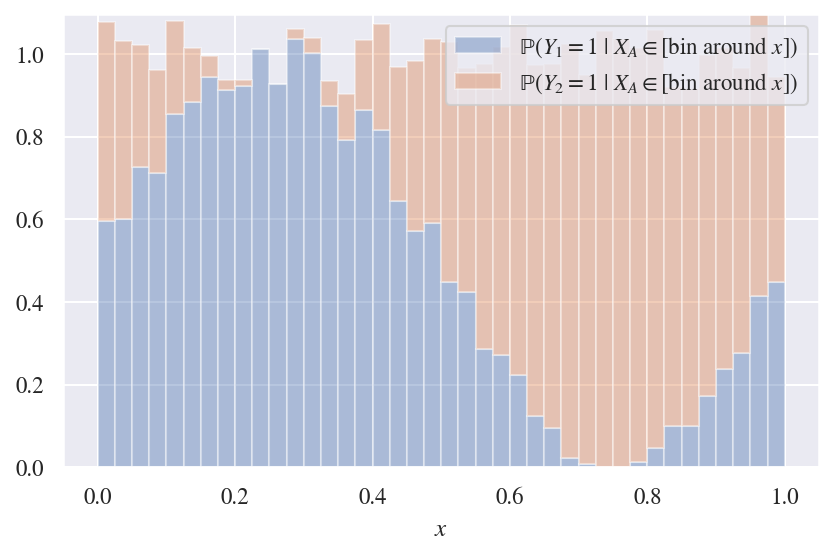

In [7]:
demo_train = True
if demo_train:
    situation = "$X_{\mathrm{A}};\ \mathbf{p}_2$"
    # situation = "$X_{\mathrm{B}};\ \mathbf{p}_2$"
    # situation = "$X_{\mathrm{A}};\ \mathbf{p}_3$"
    train = SimulateData(situation, 8192, seed=0)
    train.visualize(save_to_pdf=True)
    val = SimulateData(situation, VAL_SIZE, seed=1)
    test = SimulateData(situation, TEST_SIZE, seed=TEST_SEED)

Model: "L-10-m_0-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_0__to__m_1 (Dense)         (None, 18)                36        
_________________________________________________________________
m_1__to__m_2 (Dense)         (None, 18)                342       
_________________________________________________________________
m_2__to__m_3 (Dense)         (None, 18)                342       
_________________________________________________________________
m_3__to__m_4 (Dense)         (None, 18)                342       
_________________________________________________________________
m_4__to__m_5 (Dense)         (None, 18)                342       
_________________________________________________________________
m_5__to__m_6 (Dense)         (None, 18)                342       
_________________________________________________________________
m_6__to__m_7 (Dense)         (None, 18)                3

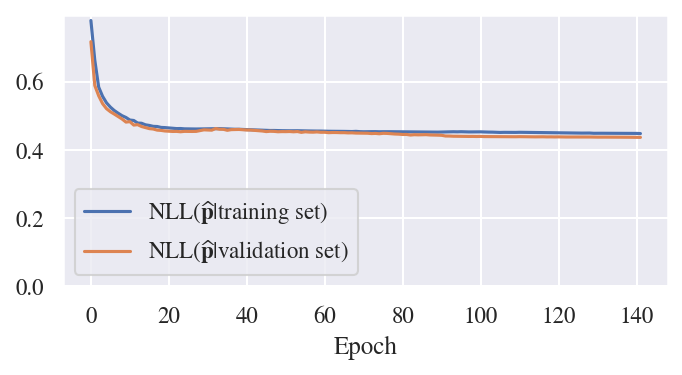

NLL train labels : 0.39493272
NLL train prob. : 0.39188588
NLL val. labels : 0.39118493
NLL val. prob. : 0.3886617
KL train labels : 0.3949313
KL train prob. : 0.003707009
KL val. labels : 0.39118347
KL val. prob. : 0.0037551727
MSE train prob. : 0.12828735
MSE val. prob. : 0.0008159906
NLL test prob. : 0.38909027
Median NLL test labels : 0.3898707
KL test prob. : 0.00375822
Median KL test labels : 0.3898693
MSE test prob. : 0.00082387915
Max test prob. difference : 0.10976870188263488
Biases > 0.001 : 71
# of biases : 182
Weights > 0.001 : 552
# of weights : 2970
Biases > 1 : 0
Weights > 1 : 10
Nr. of epochs : 142
Training seed : 0
Network seed : 2
Note : No bias reg or bounds. He normal. .005 min delta, 500 epochs, 10% patience, bs 128.


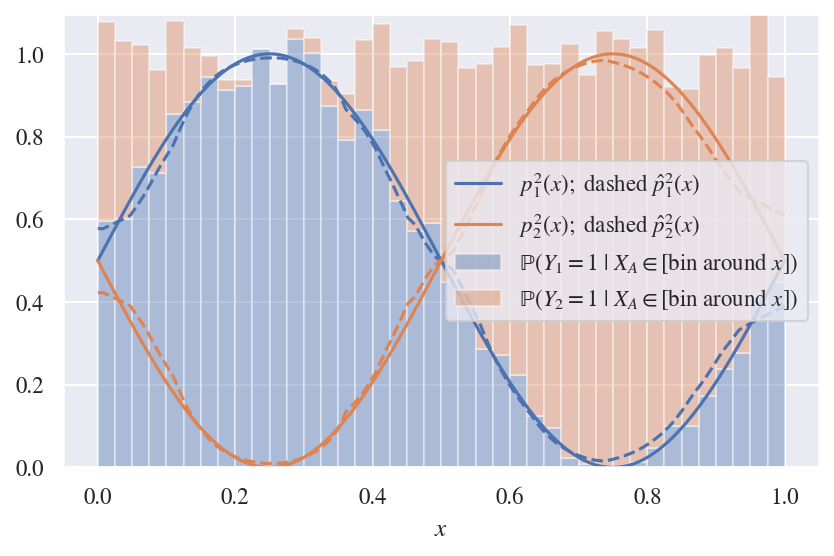

In [8]:
if demo_train:
    # params = {'lr': 0.0005, 'l1': 0.0002, 'L_star': .05, 'm_star': 0.35}
    keras_model = SingleNetwork(train, val, hidden_widths=[18 for _ in range(10)], l1=.0002)
    keras_model.train_network(opt=.0005, viz=2, seed=2)
    ev = keras_model.evaluate(test, save_to_pdf=True)
    dict_printer(ev)

# Parameter optimization

This is where we definitely start needing storage.

In [9]:
def hidden_width_converter(n, m_star, L_star):
    L = round(math.log(n, 1.04) * L_star)
    return [round(n ** m_star) for _ in range(L)]

def opt_network(situation, n, evals, viz=1):
    param_space = {
        'L_star': hyperopt.hp.uniform('L_star', .02, .08),
        'm_star': hyperopt.hp.uniform('m_star', .2, .5),
        'lr': hyperopt.hp.uniform('lr', 0.0001, 0.001),
        'l1': hyperopt.hp.uniform('l1', 0.0001, 0.001),
    }
    
    print(f"Searching optimal {param_space.keys()} in {evals} attempts.")
    print(f"We're in situation {situation} with {n} samples.")

    def obj(params):
        # New train, val; old test; single network.
        hw = hidden_width_converter(n, params['m_star'], params['L_star'])
        print(params, hw)
        
        train = SimulateData(situation, n)  # there's no default seed; this is random
        val = SimulateData(situation, VAL_SIZE)
        kn = SingleNetwork(train, val, hidden_widths=hw, l1=params['l1'])
        kn.train_network(opt=params['lr'])
        kn.evaluate(test)
        # print(f"Number of epochs: {len(kn.history.history['loss'])}")
        return kn.losses["KL test prob."]

    filename = f"{HYPEROPT_FOLDER}{situation}__{n}.hyperopt".replace('\\', '')
    # Resume from file if possible
    try: 
        trials = pickle.load(open(filename, "rb"))
        if evals <= len(trials.trials):
            trials.vals
            losses = np.asarray(trials.losses(), dtype=float)
            best_i = np.argmin(losses)
            best_params = {key: values[best_i] for key, values in trials.vals.items()}
            print("Already did", len(trials.trials), ">=", evals, "trials")
            return best_params, trials
        print(f"Found {len(trials.trials)} trials, so doing {evals - len(trials.trials)}.")
    except:
        if evals == 0:
            raise ValueError(f'evals == 0 and no {filename} found.')
        print(f"{filename} not found, starting trials from scratch.")
        trials = hyperopt.Trials()

    test = SimulateData(situation, TEST_SIZE, 2 * TEST_SEED)

    tpe_best = hyperopt.fmin(fn=obj, space=param_space, algo=hyperopt.tpe.suggest, 
                             max_evals=evals, trials=trials)
    with open(filename, "wb") as f:
        pickle.dump(trials, f)

    return tpe_best, trials

In [10]:
if False:
    def label_param(param):
        if param == 'lr': return 'learning rate'
        elif param == 'l1': return '$\lambda$'
        elif param == 'L_star': return '$L^*$'
        elif param == 'm_star': return '$m^*$'
        else: return param


    HYPEROPT_FOLDER = 'hyperopt/'
    n_list = [2 ** 13, 2 ** 16]
    viz = True  # also PDF

    situation_list = [
        "$X_{\mathrm{B}};\ \mathbf{p}_2$",
        "$X_{\mathrm{A}};\ \mathbf{p}_3$",
        "$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_5$"
    ]

    for n in n_list:
        for situation in situation_list:
            for j in range(1, 30):
                tpe_best, trials = opt_network(situation, n, j, viz)
                dict_printer(tpe_best, digits=7)

            if viz:
                old_size = plt.rcParams["figure.figsize"] 
                plt.rcParams["figure.figsize"] = (3, 2)
                params = ['lr', 'l1', 'L_star', 'm_star']
                values = {param: [] for param in params}
                losses = []
                for trial in trials.trials:
                    losses.append(trial['result']['loss'])
                    for param in params:
                        values[param].append(trial['misc']['vals'][param][0])
                for i, param in enumerate(values.keys()):
                    # plt.figure()
                    fig, ax = plt.subplots()
                    plt.title('')
                    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
                    plt.ylabel('Value of ' + label_param(param))
                    if i >= 2: # will put in a 2x2 grid, don't need 4 x labels
                        plt.xlabel('Estimated KL divergence risk')
                    plt.scatter(losses, values[param], alpha=.7)
                    s = f'Pictures/hyperopt_{situation}_{n}_{param}.pdf'
                    plt.savefig(s, format='pdf', pad_inches=0.05, bbox_inches='tight')
                plt.show()

                plt.rcParams["figure.figsize"] = old_size

# Experimental set-up

In [11]:
def exp_setup(situation, n, params, n_repeats, test=None, min_retrains=1):
    print()
    filename = f"{LOSS_FOLDER}{situation}__{n}.pkl".replace('\\', '')
    print(filename[:-4])
    try:
        results_pkl = pickle.load(open(filename, "rb"))
    except:
        print(f"Couldn't find {os.getcwd()}/{filename}")
        results_pkl = defaultdict(list)
    val_loss_key = 'NLL val. labels'
    n_found = len(results_pkl[val_loss_key])

    print(f"{situation, n} -- evaluating on test {n_repeats} time(s) (found {n_found})",
          f"with learning rate {params['lr']}, L1 penalty {params['l1']},")
    hw = hidden_width_converter(n, params['m_star'], params['L_star'])
    print('and hidden layers', hw)
    opt = optimizers.Adam(params['lr'])

    if n_found > 0:
        print(f'Found validation losses {results_pkl[val_loss_key]}')

    for i in range(n_found, n_repeats):
        print(f"Training seed {i}")
        train = SimulateData(situation, n, seed=i)
        val = SimulateData(situation, VAL_SIZE, seed=i+1)
        val_losses = []
        NLL_val_losses = []
        KL_val_losses = []
        MSE_val_losses = []
        networks = []
        for j in range(min_retrains):
            ns = n + i * min_retrains + j
            km = SingleNetwork(train, val, hw, params['l1'])
            km.train_network(opt=opt, seed=ns)
            e = len(km.history.history['loss'])
            print(f"Network seed {ns}: validation loss {km.losses[val_loss_key]} after {e} epochs")
            networks.append(km)
            val_losses.append(km.losses[val_loss_key])
            NLL_val_losses.append(km.losses['NLL val. prob.'])
            KL_val_losses.append(km.losses['KL val. prob.'])
            MSE_val_losses.append(km.losses['MSE val. prob.'])
        b = np.argmin(val_losses)
        # print(f"Training set {i} validation losses {val_losses}; picking network {b}")
        best_km = networks[b]

        # Update the dict on disk in every iteration
        if test is None:
            test = SimulateData(situation, TEST_SIZE, seed=TEST_SEED)
        results_i = best_km.evaluate(test)
        for key in results_i.keys():
            if i < n_found:
                results_pkl[key][i] = results_i[key]
            else:
                results_pkl[key].append(results_i[key])
        for key in params.keys():
            if i < n_found:
                results_pkl[key][i] = params[key]
            else:
                results_pkl[key].append(params[key])
        results_pkl['All val. loss values'].append(val_losses)
        results_pkl['All NLL val. prob. values'].append(NLL_val_losses)
        results_pkl['All KL val. prob. values'].append(KL_val_losses)
        results_pkl['All MSE val. prob. values'].append(MSE_val_losses)
        with open(filename, "wb") as f:
            pickle.dump(results_pkl, f)

        best_km.model.save(f"{filename[:-4]}__train_{i}__net_{j}")

    return results_pkl

# Experiments

In [12]:
situation_list = [
    "$X_{\mathrm{A}};\ \mathbf{p}_2$",  
    "$X_{\mathrm{B}};\ \mathbf{p}_1$",
    "$X_{\mathrm{B}};\ \mathbf{p}_2$",
    "$X_{\mathrm{A}};\ \mathbf{p}_3$",
    "$X_{\mathrm{A}};\ \mathbf{p}_4$",
    "$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_5$",
    "$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_6$",
]

n_list = [2 ** j for j in range(12, 17)]

params = {'lr': 0.0005, 'l1': 0.0002, 'L_star': .05, 'm_star': 0.35}
for n in n_list: print(n, hidden_width_converter(n, params['m_star'], params['L_star']))

4096 [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
8192 [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
16384 [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
32768 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38]
65536 [49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49]


In [13]:
n_repeats = 40
for i, situation in enumerate(situation_list):
    test = None
    # test = SimulateData(situation, TEST_SIZE, seed=TEST_SEED)
    for j, n in enumerate(n_list):
        results_pkl = exp_setup(situation, n, params, n_repeats, test)
        # dict_printer(results_pkl)


test_losses/$X_{mathrm{A}}; mathbf{p}_2$__4096
('$X_{\\mathrm{A}};\\ \\mathbf{p}_2$', 4096) -- evaluating on test 40 time(s) (found 40) with learning rate 0.0005, L1 penalty 0.0002,
and hidden layers [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Found validation losses [0.3917149, 0.3956397, 0.39981705, 0.39604935, 0.38887006, 0.38984928, 0.38306937, 0.39503315, 0.38590574, 0.3955519, 0.39251733, 0.40018672, 0.38865224, 0.39131266, 0.38320738, 0.38639623, 0.38587797, 0.38722655, 0.38572338, 0.39040402, 0.40528423, 0.38423446, 0.39305994, 0.39848834, 0.39145473, 0.3952819, 0.39313856, 0.3953264, 0.3979715, 0.3848378, 0.38451406, 0.38921976, 0.40108165, 0.40161517, 0.38302642, 0.38381344, 0.39280912, 0.38983336, 0.3976417, 0.39419994]

test_losses/$X_{mathrm{A}}; mathbf{p}_2$__8192
('$X_{\\mathrm{A}};\\ \\mathbf{p}_2$', 8192) -- evaluating on test 40 time(s) (found 40) with learning rate 0.0005, L1 penalty 0.0002,
and hidden layers [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Found valid

# Evaluating results

In [14]:
print(f'Getting results from {LOSS_FOLDER}')
found_situation_list = []
found_n_list = []
all_results = {}
_, _, filenames = next(os.walk(LOSS_FOLDER))
for f in filenames:
    situation, npkl = f.split('__')
    if situation not in found_situation_list: 
        found_situation_list.append(situation)
    n = int(npkl[:-4])
    if n not in found_n_list: 
        found_n_list.append(n)
    f_results = pickle.load(open(LOSS_FOLDER + f, "rb"))
    try:
        all_results[situation][n] = f_results
    except:
        all_results[situation] = {n: f_results}

for k in all_results.keys():
    print(k)
    for k2 in all_results[k]:
        print(k2, all_results[k][k2])
    print()

Getting results from test_losses/
$X_{mathrm{A}}; mathbf{p}_2$
4096 defaultdict(<class 'list'>, {'NLL val. labels': [0.3917149, 0.3956397, 0.39981705, 0.39604935, 0.38887006, 0.38984928, 0.38306937, 0.39503315, 0.38590574, 0.3955519, 0.39251733, 0.40018672, 0.38865224, 0.39131266, 0.38320738, 0.38639623, 0.38587797, 0.38722655, 0.38572338, 0.39040402, 0.40528423, 0.38423446, 0.39305994, 0.39848834, 0.39145473, 0.3952819, 0.39313856, 0.3953264, 0.3979715, 0.3848378, 0.38451406, 0.38921976, 0.40108165, 0.40161517, 0.38302642, 0.38381344, 0.39280912, 0.38983336, 0.3976417, 0.39419994], 'NLL train labels': [0.38126862, 0.375365, 0.40001494, 0.37351358, 0.3913537, 0.3913477, 0.38491893, 0.38799137, 0.39401776, 0.39425534, 0.37561828, 0.3952498, 0.388313, 0.385728, 0.388371, 0.39994124, 0.3911546, 0.38942876, 0.39562982, 0.38899708, 0.3780124, 0.3782309, 0.38016528, 0.3950435, 0.397692, 0.3975163, 0.39941448, 0.38678595, 0.39826623, 0.3878142, 0.38813567, 0.37854108, 0.37102872, 0.38399088, 

In [15]:
situation_lists = [[
    "$X_{\mathrm{A}};\ \mathbf{p}_2$",  
    "$X_{\mathrm{B}};\ \mathbf{p}_1$",
    "$X_{\mathrm{B}};\ \mathbf{p}_2$",
], [
    "$X_{\mathrm{A}};\ \mathbf{p}_3$",
    "$X_{\mathrm{A}};\ \mathbf{p}_4$",
    "$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_5$",
    "$\mathbf{X}_{\mathrm{C}};\ \mathbf{p}_6$",
]]  # could use found_situation_list, found_n_list; next functions default to sth like that.

n_list = [2 ** j for j in range(12, 18)]

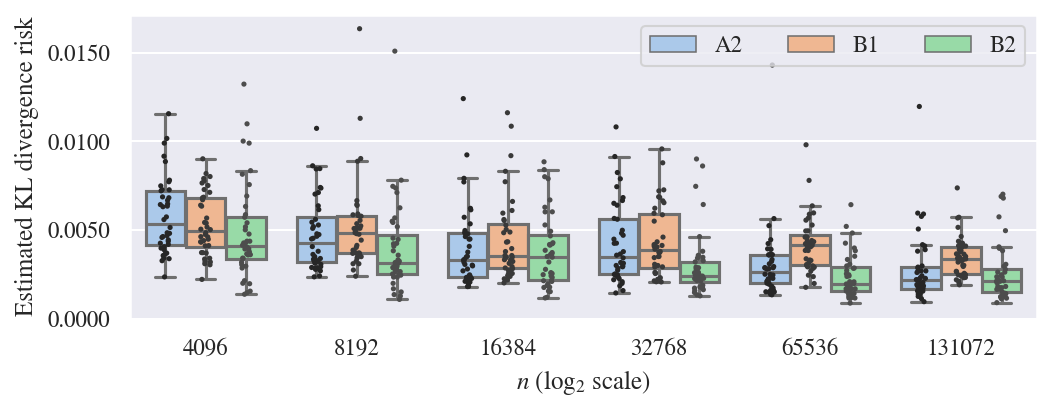

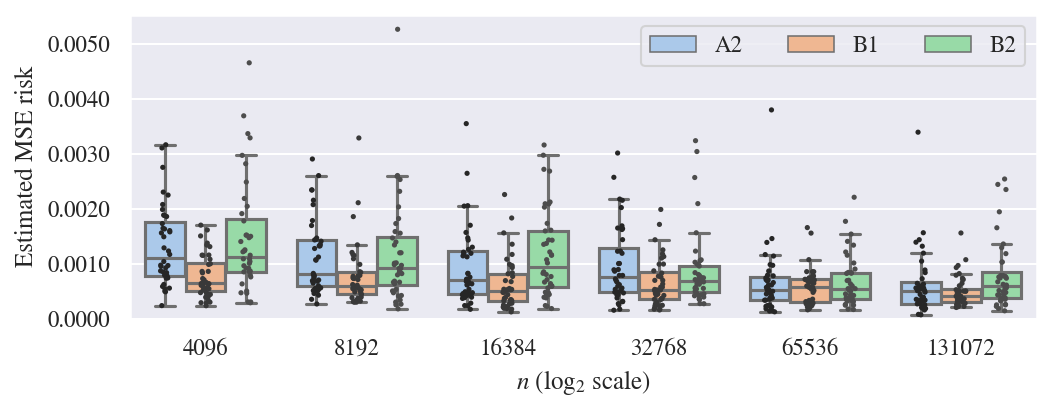

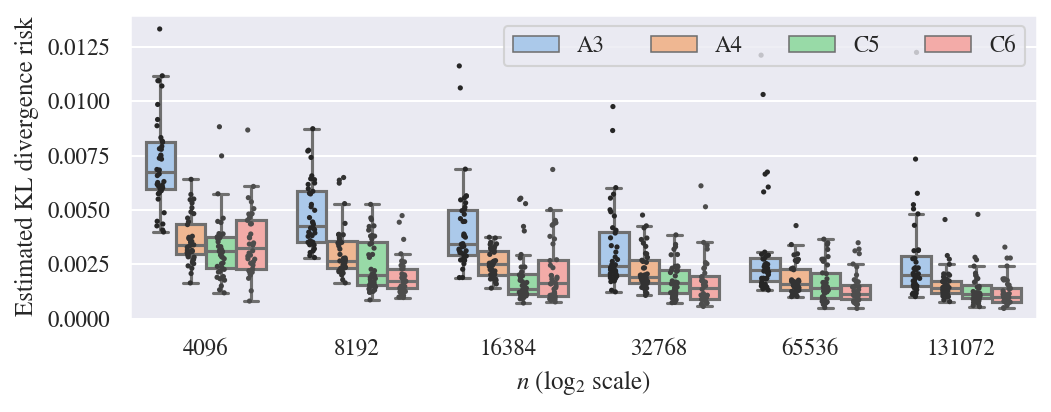

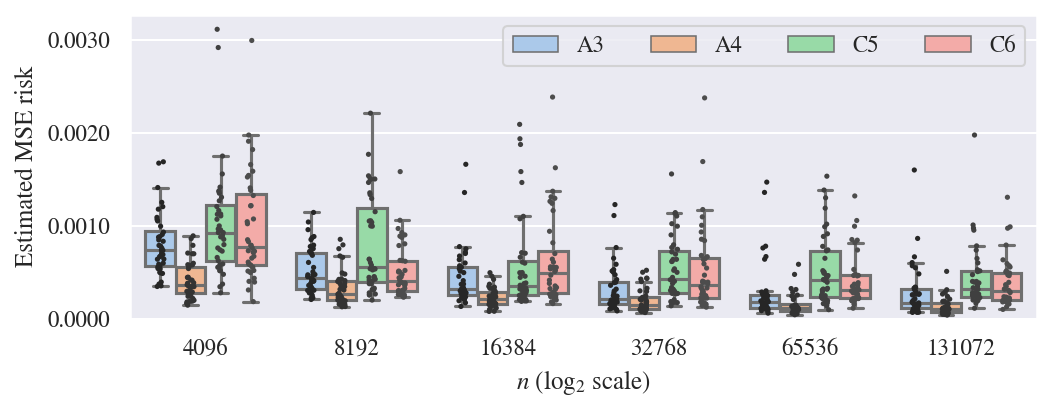

In [16]:
def label_quantity(q): 
    if q == 'KL test prob.':
        return 'Estimated KL divergence risk'
    elif q == 'MSE test prob.':
        return 'Estimated MSE risk'
    else:
        return q

def label_situation(sit, short=False):
    letter, number = sit_to_let_num(sit, True)
    return f'{letter}{number}'# ({q})' 

def quantity_situation_n_boxplot(quantity, all_results, situation_list=None, n_list=None, 
                                 save_to_pdf=False, max_y=None):
    old_size = plt.rcParams["figure.figsize"] 
    plt.rcParams["figure.figsize"] = (old_size[0] * 1.2, old_size[1] * 0.67)
    if situation_list is None:
        situation_list = list(all_results.keys())
    if n_list is None:
        n_list = list(all_results[situation_list[0]].keys())
    pd_df = pd.DataFrame()
    for situation in situation_list:
        for i, n in enumerate(n_list):
            quantities = all_results[situation.replace('\\', '')][n][quantity]
            if isinstance(quantities[-1], list):
                quantities = [q for sublist in quantities for q in sublist]
            n_rep = np.repeat(n, len(quantities))
            sit_rep = np.repeat(label_situation(situation), len(quantities))
            pd_df = pd_df.append(pd.DataFrame({'$n$': n_rep, quantity: quantities, 
                                               'Situation': sit_rep}))
    ax = sns.stripplot(x="$n$", y=quantity, hue="Situation", data=pd_df, dodge=True, color='.3',
                       marker='.')
    ax = sns.boxplot(x="$n$", y=quantity, hue="Situation", data=pd_df, #whis=np.inf, 
                     palette='pastel', fliersize=0)

    handles, labels = ax.get_legend_handles_labels()
    # Make a first empty label that's a placeholder for A1
    if len(situation_list) == 7:
        r = matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False)
        handles.insert(0, r)
        labels.insert(0, "")
        plt.legend(handles[0:len(situation_list)+1], labels[0:len(situation_list)+1], ncol=4)
    else:
        plt.legend(handles[0:len(situation_list)], labels[0:len(situation_list)], ncol=4)

    plt.xlabel('$n$ ($\log_2$ scale)')
    ax.set_ylabel(label_quantity(quantity))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
    if max_y: ax.set_ylim((0, max_y))
    else: ax.set_ylim((0, plt.axis()[3]))
    if save_to_pdf:
        codes = ""
        for sit in situation_list:
            letter, number = sit_to_let_num(sit)
            codes += f"_{letter}{number}"
        s = f'Pictures/plot_{quantity}_{codes}.pdf'#__{min(n_list)}-{max(n_list)}.pdf'
        plt.savefig(s, format='pdf', pad_inches=0.01, bbox_inches='tight')
    plt.show()
    plt.rcParams["figure.figsize"] = old_size
    return pd_df

for situation_list in situation_lists:
    settings = (all_results, situation_list, n_list, True)
    quantity_situation_n_boxplot('KL test prob.', *settings);
    quantity_situation_n_boxplot('MSE test prob.', *settings);
    # quantity_situation_n_boxplot('Nr. of epochs', *settings);
    # quantity_situation_n_boxplot('Weights > 0.001', *settings);

The SciPy fit of A2 is $0.0021\ n^{-0.4436}\ (\log \ n)^2$ for MSE 0.044083
The SciPy fit of B1 is $0.0007\ n^{-0.3172}\ (\log \ n)^2$ for MSE 0.042859
The SciPy fit of B2 is $0.0016\ n^{-0.4317}\ (\log \ n)^2$ for MSE 0.021007


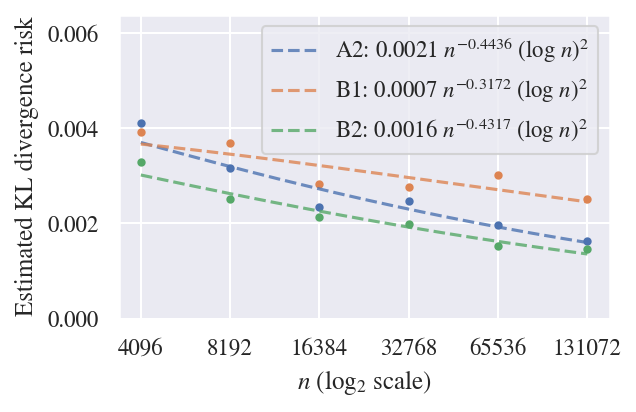

The SciPy fit of A2 is $0.0006\ n^{-0.4806}\ (\log \ n)^2$ for MSE 0.040609
The SciPy fit of B1 is $0.0001\ n^{-0.3395}\ (\log \ n)^2$ for MSE 0.090013
The SciPy fit of B2 is $0.0004\ n^{-0.4443}\ (\log \ n)^2$ for MSE 0.05106


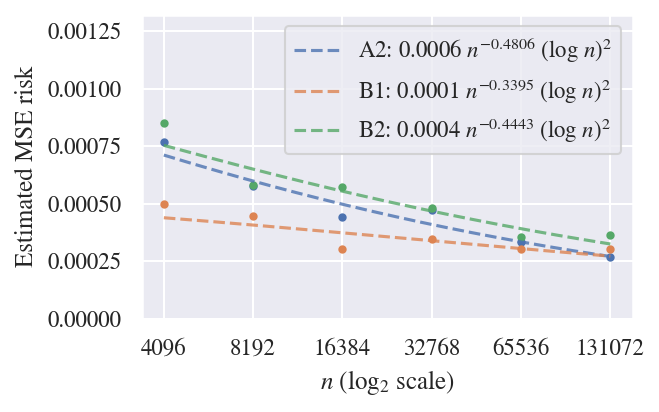

The SciPy fit of A3 is $0.0091\ n^{-0.5838}\ (\log \ n)^2$ for MSE 0.07541
The SciPy fit of A4 is $0.0021\ n^{-0.4722}\ (\log \ n)^2$ for MSE 0.008381
The SciPy fit of C5 is $0.0011\ n^{-0.4434}\ (\log \ n)^2$ for MSE 0.098822
The SciPy fit of C6 is $0.0013\ n^{-0.4742}\ (\log \ n)^2$ for MSE 0.121402


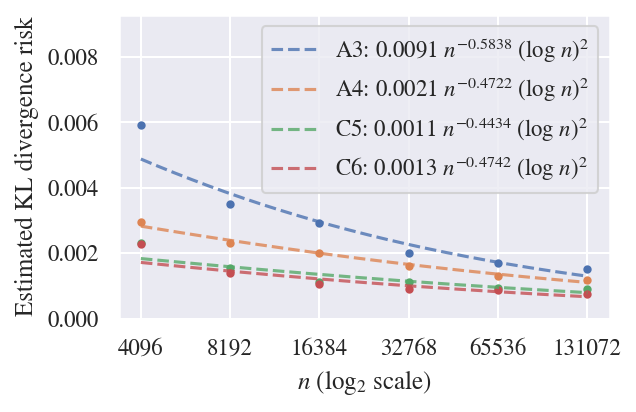

The SciPy fit of A3 is $0.0021\ n^{-0.6914}\ (\log \ n)^2$ for MSE 0.115055
The SciPy fit of A4 is $0.0006\ n^{-0.6195}\ (\log \ n)^2$ for MSE 0.021729
The SciPy fit of C5 is $0.0003\ n^{-0.4423}\ (\log \ n)^2$ for MSE 0.178545
The SciPy fit of C6 is $0.0002\ n^{-0.4317}\ (\log \ n)^2$ for MSE 0.161698


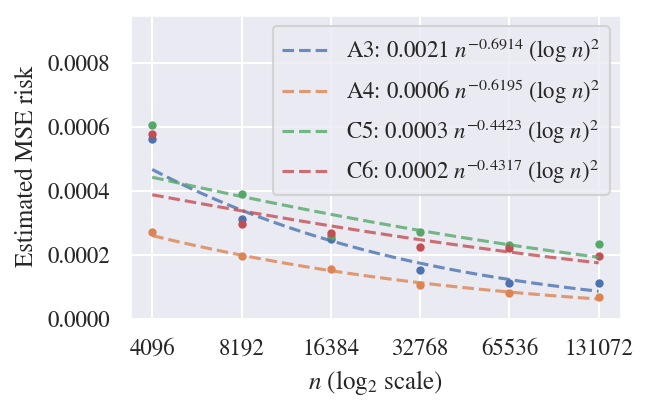

In [17]:
def plot_min_fit(quantity, all_results, situation_list=None, n_list=None, save_to_pdf=False):
    old_size = plt.rcParams["figure.figsize"] 
    plt.rcParams["figure.figsize"] = (old_size[0] * 0.65, old_size[1] * 0.67)
    fig1, ax1 = plt.subplots()
    # plt.figure(0)
    quantities_list = []
    if situation_list is None: situation_list = list(all_results.keys())
    if n_list is None: n_list = sorted(all_results[situation_list[0]].keys())
    
    def get_res(quants_for_sit):
        return [np.quantile(q_vals, .25, interpolation='midpoint') for q_vals in quants_for_sit]

    for situation in situation_list:
        quants_for_sit = [all_results[situation.replace('\\', '')][n][quantity] for n in n_list]
        ls = label_situation(situation)
        ax1.scatter(n_list, get_res(quants_for_sit), marker='.', alpha=1,)# label=ls)
        quantities_list.append(quants_for_sit)

    # Start of fitting block
    for i, situation in enumerate(situation_list):
        quants_for_sit = quantities_list[i]
        y_2d = get_res(quants_for_sit)
        y = np.reshape(y_2d, (1,-1))[0] # 1d

        def chisq_n_y(theta):
            diff = y - (theta[0] * n_list ** theta[1] * np.log(n_list) ** 2)
            diff /= y
            return sum(diff ** 2)
        res = scipy.optimize.dual_annealing(chisq_n_y, [(0, 1), (-1, 0)], seed=0)
        formula = f"${res.x[0].round(4)}\ n^{{{res.x[1].round(4)}}}\ (\log \ n)^2$"
        ls_s = label_situation(situation, True)
        print(f'The SciPy fit of {ls_s} is {formula} for MSE {round(res.fun, 6)}')

        n_space = np.linspace(min(n_list), max(n_list), 10 ** 4)
        ax1.plot(n_space, res.x[0] * n_space ** res.x[1] * np.log(n_space) ** 2, '--', alpha=.8,
                #  label=f"{label_situation(situation)}: $\\theta_2 = {res.x[1].round(4)}$")
                label=f"{label_situation(situation)}: {formula}",)

    ax1.set_ylabel(label_quantity(quantity))
    ax1.set_xlabel("$n$ ($\log_2$ scale)")
    ax1.set_xscale('log')
    ax1.set_xticks(n_list)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.set_ylim(0, 1.5 * plt.axis()[3])
    plt.legend(loc='upper right',)
    if save_to_pdf:
        codes = ""
        for sit in situation_list:
            letter, number = sit_to_let_num(sit)
            codes += f"_{letter}{number}"
        s = f'Pictures/fit_{quantity}_{codes}_{min(n_list)}-{max(n_list)}.pdf'
        plt.savefig(s, format='pdf', pad_inches=0.01, bbox_inches='tight')
    
    plt.show()
    plt.rcParams["figure.figsize"] = old_size


for situation_list in situation_lists:
    settings = (all_results, situation_list, n_list, True)
    plot_min_fit('KL test prob.', *settings);
    plot_min_fit('MSE test prob.', *settings);

# Alternative experimental set-up


In [ ]:
def alternative_exp_setup(situation, n, params, n_repeats, test=None, min_retrains=5, factor=1.2):
    # Writes results to a dict stored in a pkl in LOSS_FOLDER. Saved Keras models in same folder.
    # Retrains networks `min_retrains` times (first two training seeds) or (next training seeds) 
    #  until their training loss (cross-entropy) is less than `factor` times the best one.
    print()

    filename = f"{LOSS_FOLDER}{situation}__{n}.pkl".replace('\\', '')
    try:
        results_pkl = pickle.load(open(filename, "rb"))
    except:
        print(f"Couldn't find {os.getcwd()}/{filename}")
        results_pkl = defaultdict(list)
    neg_LL_train_str =  'NLL train labels'
    neg_LL_val_str = 'NLL val. labels'
    n_found = len(results_pkl[neg_LL_val_str])

    print(f"{situation, n} -- evaluating on test {n_repeats} time(s) (found {n_found})",
          f"with learning rate {params['lr']}, L1 penalty {params['l1']},")
    hw = hidden_width_converter(n, params['m_star'], params['L_star'])
    print('and hidden layers', hw)
    opt = optimizers.Adam(params['lr'])

    if n_found < 2:
        print(f"Didn't find more than 2 stored entries, training seeds 0 and 1 take longer,",
              f"will retrain with at least {min_retrains} different network seeds")
    if n_found > 1:
        print(f'Found training losses {results_pkl[neg_LL_train_str]}')
        print(f'Found validation losses {results_pkl[neg_LL_val_str]}')

    for i in range(n_repeats):
        not_doing_anything = False
        # Build up a store (min_retrains) of training losses to compare to if there is none.
        if i < 2 and n_found < 2 and i >= n_found:
            print(f"Training seed {i}")
            train = SimulateData(situation, n, seed=i)
            val = SimulateData(situation, VAL_SIZE, seed=i+1)
            neg_LLs = []
            networks = []
            for j in range(min_retrains):
                print(f'Trying network seed {j}')
                km = SingleNetwork(train, val, hidden_widths=hw, l1=params['l1'])
                km.train_network(opt=opt, seed=j)
                networks.append(km)
                neg_LLs.append(km.losses[neg_LL_train_str])
            best_km = networks[np.argmin(neg_LLs)]

        # If there is a store, retrain until not too far off the best.
        else:
            min_training_LL = np.min(results_pkl[neg_LL_train_str])
            # If there is an entry for this training seed i that was previously accepted,
            #  we may still want to retrain.
            if i < n_found:
                neg_LL = results_pkl[neg_LL_train_str][i]
                # Skip seeds (j's) that were apparently not good enough:
                if neg_LL > factor * min_training_LL:
                    print(f"Will retrain training set with seed {i}")
                    print(f'{neg_LL} < {factor} * {min_training_LL}')
                    j = results_pkl['Network seed'][i] + 1
                    train = SimulateData(situation, n, seed=i)
                    val = SimulateData(situation, VAL_SIZE, seed=i+1)
                else:
                    not_doing_anything = True
            else:
                j = 0
                print(f"Training seed {i}")
                train = SimulateData(situation, n, seed=i)
                val = SimulateData(situation, VAL_SIZE, seed=i+1)
                neg_LL = float('inf')
            while neg_LL > factor * min_training_LL:
                print(f'Trying network seed {j}')
                best_km = SingleNetwork(train, val, hidden_widths=hw, l1=params['l1'])
                best_km.train_network(opt=opt, seed=j)
                neg_LL = best_km.losses[neg_LL_train_str]
                j += 1

        # Add results of best network to big dict, store on disk
        if not not_doing_anything:
            if test is None:
                test = SimulateData(situation, TEST_SIZE, seed=TEST_SEED)
            results_i = best_km.evaluate(test)
            for key in results_i.keys():
                if i < n_found:
                    results_pkl[key][i] = results_i[key]
                else:
                    results_pkl[key].append(results_i[key])
            for key in params.keys():
                if i < n_found:
                    results_pkl[key][i] = params[key]
                else:
                    results_pkl[key].append(params[key])

            with open(filename, "wb") as f:
                pickle.dump(results_pkl, f)

            best_km.model.save(f"{LOSS_FOLDER}model__{situation}__n_{n}__train_{i}__net_{j}")

    # Now can we check whether previous training sets/seeds have bad best networks
    m = np.min(results_pkl[neg_LL_train_str])
    retrain_booleans = [l > factor * m for l in results_pkl[neg_LL_train_str]]
    print('Need to retrain (per training seed)?', retrain_booleans)
    if True in retrain_booleans:
        return evaluate_params(situation, n, params, n_repeats, test, min_retrains, factor)
    else:
        return results_pkl

In [ ]:
LOSS_FOLDER = 'alternative_test_losses/'

situation_list = [
    "$X_{\mathrm{A}};\ \mathbf{p}_2$",  
    "$X_{\mathrm{B}};\ \mathbf{p}_1$",
    "$X_{\mathrm{B}};\ \mathbf{p}_2$",
    # "$X_{\mathrm{A}};\ \mathbf{p}_3$",
    # "$X_{\mathrm{A}};\ \mathbf{p}_4$",
    # "$\mathbf{X}_{\mathrm{D}};\ \mathbf{p}_5$",
    # "$\mathbf{X}_{\mathrm{D}};\ \mathbf{p}_6$",
]

n_list = [2 ** j for j in range(12, 14)]

params = {'lr': 0.0005, 'l1': 0.0002, 'L_star': .05, 'm_star': 0.35}
for n in n_list: print(n, hidden_width_converter(n, params['m_star'], params['L_star']))

n_repeats = 20
for i, situation in enumerate(situation_list):
    test = None
    test = SimulateData(situation, TEST_SIZE, seed=TEST_SEED)
    for j, n in enumerate(n_list):
        results_pkl = alternative_exp_setup(situation, n, params, n_repeats, test)
        dict_printer(results_pkl)